In [2]:
import torch
from torch.utils.data import Dataset, TensorDataset
from torchvision.datasets import MNIST
from torchvision import transforms



class MultipleEnvironmentMNIST(Dataset):
    """
    Each data item: (image, label, domain_label)
    """
    def __init__(self, root, environments, dataset_transform, input_shape,
                 num_classes):
        super().__init__()
        if root is None:
            raise ValueError('Data directory not specified!')

        original_dataset_tr = MNIST(root, train=True, download=True)
        original_dataset_te = MNIST(root, train=False, download=True)

        original_images = torch.cat((original_dataset_tr.data,
                                     original_dataset_te.data))

        original_labels = torch.cat((original_dataset_tr.targets,
                                     original_dataset_te.targets))

        shuffle = torch.randperm(len(original_images))

        original_images = original_images[shuffle]
        original_labels = original_labels[shuffle]

        self.datasets = []

        for i in range(len(environments)):
            images = original_images[i::len(environments)]
            labels = original_labels[i::len(environments)]
            self.datasets.append(dataset_transform(images, labels, environments[i]))

        self.input_shape = input_shape
        self.num_classes = num_classes

    def __getitem__(self, idx):
        return self.datasets[idx]
    
    def __len__(self):
        return len(self.datasets)


class ColoredMNIST(MultipleEnvironmentMNIST):
    ENVIRONMENTS = ['+90%', '+80%', '-90%']

    def __init__(self, root):
        super(ColoredMNIST, self).__init__(root, [0.1, 0.2, 0.9],
                                         self.color_dataset, (2, 28, 28,), 2)

        self.input_shape = (2, 28, 28,)
        self.num_classes = 2

    def color_dataset(self, images, labels, environment):
        # # Subsample 2x for computational convenience
        # images = images.reshape((-1, 28, 28))[:, ::2, ::2]
        # Assign a binary label based on the digit
        labels = (labels < 5).float()
        # Flip label with probability 0.25
        labels = self.torch_xor_(labels,
                                 self.torch_bernoulli_(0.25, len(labels)))

        # Assign a color based on the label; flip the color with probability e
        colors = self.torch_xor_(labels,
                                 self.torch_bernoulli_(environment,
                                                       len(labels)))
        images = torch.stack([images, images], dim=1)
        # Apply the color to the image by zeroing out the other color channel
        images[torch.tensor(range(len(images))), (
            1 - colors).long(), :, :] *= 0

        x = images.float().div_(255.0)
        y = labels.view(-1).long()

        return TensorDataset(x, y)

    def torch_bernoulli_(self, p, size):
        return (torch.rand(size) < p).float()

    def torch_xor_(self, a, b):
        return (a - b).abs()


class RotatedMNIST(MultipleEnvironmentMNIST):
    ENVIRONMENTS = ['0', '15', '30', '45', '60', '75']

    def __init__(self, root):
        super(RotatedMNIST, self).__init__(root, [0, 15, 30, 45, 60, 75],
                                           self.rotate_dataset, (1, 28, 28,), 10)

    def rotate_dataset(self, images, labels, angle):
        rotation = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Lambda(lambda x: transforms.functional.rotate(x, angle, fill=(0,),
                interpolation = transforms.InterpolationMode.BILINEAR)),
            transforms.ToTensor()])

        x = torch.zeros(len(images), 1, 28, 28)
        for i in range(len(images)):
            x[i] = rotation(images[i])

        y = labels.view(-1)

        return TensorDataset(x, y)


In [21]:
import os
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms




class MultipleEnvironmentImageFolder:
    def __init__(self, root, test_envs, augment):
        super().__init__()
        environments = [f.name for f in os.scandir(root) if f.is_dir()]
        environments = sorted(environments)

        transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        augment_transform = transforms.Compose([
            # transforms.Resize((224,224)),
            transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),
            transforms.RandomGrayscale(),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.datasets = []
        for i, environment in enumerate(environments):

            if augment and (i not in test_envs):
                env_transform = augment_transform
            else:
                env_transform = transform

            path = os.path.join(root, environment)
            env_dataset = ImageFolder(path,
                transform=env_transform)

            self.datasets.append(env_dataset)

        self.input_shape = (3, 224, 224,)
        self.num_classes = len(self.datasets[-1].classes)

    def __getitem__(self, idx):
        return self.datasets[idx]

    def __len__(self):
        return len(self.datasets)


class PACS(MultipleEnvironmentImageFolder):
    CHECKPOINT_FREQ = 300
    ENVIRONMENTS = ["A", "C", "P", "S"]
    def __init__(self, root, test_envs, augment=False):
        """
        Args:
            test_envs: List[int], indices of the test enviroments. This will only affect the ways augmenting the datasets.
            augment: bool, set True to augment the training enviroments, default is False.

        Returns:
            List of datasets of all domains, List[TensorSet]. The test domains are also contained in the list.
            The order of domains in the list is always ["A", "C", "P", "S"], which is indepenedent to the chosen of train/test envs.



        """
        self.dir = os.path.join(root, "PACS/")
        super().__init__(self.dir, test_envs, augment)

In [22]:
root = '/home/chuyang/Workspace/data'

# colored_dataset = ColoredMNIST(root)
# rotated_dataset = RotatedMNIST(root)
pacs_dataset = PACS(root, [1])



In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [55]:
def show_image_from_tensor(ten, normalize=False):
    """
    ten : (tensor) shape of ten is (C, H, W)
    """
    image = ten.numpy()

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        mean = mean[:, np.newaxis, np.newaxis]
        std = std[:, np.newaxis, np.newaxis]
        mean = np.broadcast_to(mean, image.shape)
        std = np.broadcast_to(std, image.shape)
        image = image * std
        image = image + mean

    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


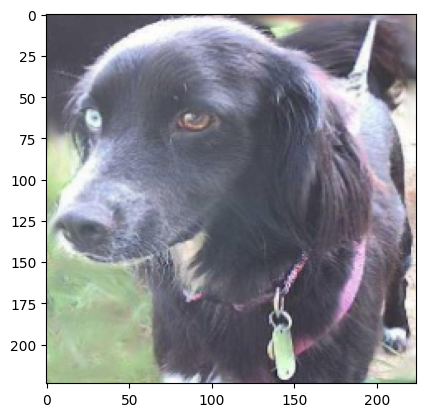

In [56]:
d = pacs_dataset[2]
show_image_from_tensor(d[2][0], True)